In [1]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MaxAbsScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_selector as selector
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.svm import SVC
from scipy.stats import loguniform, randint
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import TruncatedSVD

In [2]:
# load KSI dataset into data frame
KSI_data = pd.read_csv('KSI.csv')

In [3]:
KSI_data['ALCOHOL'] = KSI_data['ALCOHOL'].fillna('No')

# plotting number of road accidents for each hour of the day
# store original TIME columns
time_col = KSI_data['TIME'].copy()
# convert time to string and fill with 0's if necessary
KSI_data['TIME'] = KSI_data['TIME'].astype(str).str.zfill(4)
# create function to return appropriate time range for accident
def time_ranges(time):
    hour = int(time[:2])
    hour_range_start = hour // 1 * 1  
    return f'{hour_range_start:02d}:00-{hour_range_start:02d}:59'
# create new column with ranges as values
KSI_data['TimeRange'] = KSI_data['TIME'].apply(time_ranges)

# Section 2: Data modeling

In [4]:
# preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# bundling preprocessing for num and cat data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, selector(dtype_include=['int64', 'float64'])),
        ('cat', categorical_transformer, selector(dtype_include=object))
    ]
)

In [5]:
# dropping rows where ACCLASS data is NaN
KSI_data.dropna(subset=['ACCLASS'], inplace=True)

In [6]:
# make ACCLASS binary by replacing 'Property Damage Only' with 'Non-Fatal Injury'
KSI_data['ACCLASS'].replace('Property Damage Only', 'Non-Fatal Injury', inplace=True)

In [7]:
# revert changes made to time column
KSI_data['TIME'] = time_col

In [8]:
# drop TimeRange column
KSI_data.drop(['TimeRange'], axis=1, inplace=True)

In [9]:
# replace missing values with "No" in various features
# this was already done to ALCOHOL in Section 1
values = {
    'PEDESTRIAN': 'No',
    'CYCLIST': 'No',
    'AUTOMOBILE': 'No',
    'MOTORCYCLE': 'No',
    'TRUCK': 'No',
    'TRSN_CITY_VEH': 'No',
    'EMERG_VEH': 'No',
    'PASSENGER': 'No',
    'SPEEDING': 'No',
    'AG_DRIV': 'No',
    'REDLIGHT': 'No',
    'DISABILITY': 'No'
}
KSI_data.fillna(value=values, inplace=True)

In [10]:
# feature selection
features_to_drop = ['ACCLASS', 'INJURY', 'OFFSET', 'FATAL_NO', 'DRIVACT',
                    'DRIVCOND', 'PEDTYPE', 'PEDACT', 'PEDCOND', 'CYCLISTYPE',
                    'CYCACT', 'CYCCOND', 'YEAR', 'DATE', 'X', 'Y', 'STREET1',
                    'STREET2', 'DISTRICT', 'WARDNUM', 'ACCLOC', 'HOOD_158',
                    'NEIGHBOURHOOD_158', 'HOOD_140', 'NEIGHBOURHOOD_140',
                    'DIVISION', 'INDEX_', 'ACCNUM', 'ObjectId']
X = KSI_data.drop(features_to_drop, axis=1)
y = KSI_data['ACCLASS']

In [11]:
# splitting dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Section 3: Predictive model building

## Logistic regression

In [12]:
# model pipeline
pipeline_lr = Pipeline([
    ('preprocessor', preprocessor),
    ('scaler', MaxAbsScaler()),
    ('classifier', LogisticRegression(solver='saga', max_iter=5000))
])

In [13]:
# randomizedsearchcv params
param_dist_lr = {
    'classifier__C': loguniform(1e-4, 10)
}

In [14]:
# gridsearchcv params
param_grid_lr = {
    'classifier__C': [0.01, 0.1, 1, 10],
    'classifier__max_iter': [2000, 5000, 10000]
}

In [15]:
# setting up grid search
grid_search_lr = GridSearchCV(estimator=pipeline_lr, param_grid=param_grid_lr, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

In [16]:
# setting up random grid search
random_search_lr = RandomizedSearchCV(estimator=pipeline_lr, param_distributions=param_dist_lr, n_iter=20, cv=5, scoring='accuracy', verbose=1, random_state=42, n_jobs=-1)

In [17]:
# fitting grid search
grid_search_lr.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x000002AB530E46D0>),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x000002AB530E4670>)])),
                                       ('scaler', MaxAbsScaler()),
                                       ('classifier',
                                        LogisticRegression(max_iter=5000,
                                                           solver='saga'))]),
             n_jobs=-1,
             param_grid={'classifier__C': [0.01, 0.1, 1, 10],
                         'classifier__max_iter': [2000, 5000, 10000]},
             scoring='accuracy', verbose=1)

In [18]:
# fitting random grid search
random_search_lr.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               <sklearn.compose._column_transformer.make_column_selector object at 0x000002AB530E46D0>),
                                                                              ('cat',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='most_frequ...
                                                                               <sklearn.compose._column_transformer.make_column_selector object at 0x000002AB530E4670>)])),
                                             ('scaler', MaxAbsScaler()),
                                             ('classifier',
                                              LogisticRegression(max_iter=5000,
                                                                 solver='saga'))]),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'classifier__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000002AB41973460>},
                   random_state=42, scoring='accuracy', verbose=1)

In [19]:
# best params and best score grid search LOGISTIC REGRESSION
print("Best parameters for Logistic Regression:", grid_search_lr.best_params_)
print("Best score for Logistic Regression:", grid_search_lr.best_score_)

Best parameters for Logistic Regression: {'classifier__C': 0.1, 'classifier__max_iter': 2000}
Best score for Logistic Regression: 0.8623460956839857


In [20]:
# best params and best score randomized grid search LOGISTIC REGRESSION
print("Best parameters for Logistic Regression (Randomized):", random_search_lr.best_params_)
print("Best score for Logistic Regression (Randomized):", random_search_lr.best_score_)

Best parameters for Logistic Regression (Randomized): {'classifier__C': 0.3470266988650412}
Best score for Logistic Regression (Randomized): 0.8624148242063224


## Decision trees

In [21]:
# model pipeline
pipeline_dt = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

# gridsearchcv params
param_grid_dt = {
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 10, 20],
    'classifier__min_samples_leaf': [1, 5, 10]
}

# randomizedsearchcv params
param_dist_dt = {
    'classifier__max_depth': randint(5, 50),
    'classifier__min_samples_split': randint(2, 20),
    'classifier__min_samples_leaf': randint(1, 10)
}

# setting up grid search
grid_search_dt = GridSearchCV(estimator=pipeline_dt, param_grid=param_grid_dt, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

# setting up random grid search
random_search_dt = RandomizedSearchCV(estimator=pipeline_dt, param_distributions=param_dist_dt, n_iter=20, cv=5, scoring='accuracy', verbose=1, random_state=42, n_jobs=-1)

In [22]:
# fitting grid search
grid_search_dt.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x000002AB530E46D0>),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent'))...
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x000002AB530E4670>)])),
                                       ('classifier',
                                        DecisionTreeClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__max_depth': [None, 10, 20, 30],
                         'classifier__min_samples_leaf': [1, 5, 10],
                         'classifier__min_samples_split': [2, 10, 20]},
             scoring='accuracy', verbose=1)

In [23]:
# fitting random grid search
random_search_dt.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               <sklearn.compose._column_transformer.make_column_selector object at 0x000002AB530E46D0>),
                                                                              ('cat',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='most_frequ...
                   param_distributions={'classifier__max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002AB533648B0>,
                                        'classifier__min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002AB53247A30>,
                                        'classifier__min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002AB53247A60>},
                   random_state=42, scoring='accuracy', verbose=1)

In [24]:
# best params and best score DECISION TREE
print("Best parameters for Decision Tree:", grid_search_dt.best_params_)
print("Best score for Decision Tree:", grid_search_dt.best_score_)

# best params and best score randomized grid search DECISION TREE
print("Best parameters for Decision Tree (Randomized):", random_search_dt.best_params_)
print("Best score for Decision Tree (Randomized):", random_search_dt.best_score_)

Best parameters for Decision Tree: {'classifier__max_depth': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2}
Best score for Decision Tree: 0.8938213270908664
Best parameters for Decision Tree (Randomized): {'classifier__max_depth': 12, 'classifier__min_samples_leaf': 3, 'classifier__min_samples_split': 15}
Best score for Decision Tree (Randomized): 0.873273080777853


## SVM

In [25]:
# model pipeline
pipeline_svm = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', SVC(random_state=42, probability=True))
])

# gridsearchcv params
param_grid_svm = {
    'classifier__C': [1, 10],
    'classifier__kernel': ['rbf']
}

# randomizedsearchcv params
param_dist_svm = {
    'classifier__C': loguniform(1e-1, 10),
    'classifier__gamma': loguniform(1e-4, 1e-1),
    'classifier__kernel': ['rbf']
}

# setting up grid search
grid_search_svm = GridSearchCV(estimator=pipeline_svm, param_grid=param_grid_svm, cv=3, scoring='accuracy', verbose=1, n_jobs=-1)

# setting up random grid search
random_search_svm = RandomizedSearchCV(estimator=pipeline_svm, param_distributions=param_dist_svm, n_iter=10, cv=3, scoring='accuracy', verbose=1, n_jobs=-1, random_state=42)

In [26]:
# fitting grid search
grid_search_svm.fit(X_train, y_train)

Fitting 3 folds for each of 2 candidates, totalling 6 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x000002AB530E46D0>),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x000002AB530E4670>)])),
                                       ('classifier',
                                        SVC(probability=True,
                                            random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__C': [1, 10],
                         'classifier__kernel': ['rbf']},
             scoring='accuracy', verbose=1)

In [27]:
# fitting random grid search
random_search_svm.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               <sklearn.compose._column_transformer.make_column_selector object at 0x000002AB530E46D0>),
                                                                              ('cat',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='most_frequ...
                                             ('classifier',
                                              SVC(probability=True,
                                                  random_state=42))]),
                   n_jobs=-1,
                   param_distributions={'classifier__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000002AB532F5DF0>,
                                        'classifier__gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000002AB532659A0>,
                                        'classifier__kernel': ['rbf']},
                   random_state=42, scoring='accuracy', verbose=1)

In [28]:
# best params and best score SVM
print("Best parameters for SVM:", grid_search_svm.best_params_)
print("Best score for SVM:", grid_search_svm.best_score_)

# best params and best score randomized grid search SVM
print("Best parameters for SVM (Randomized):", random_search_svm.best_params_)
print("Best score for SVM (Randomized):", random_search_svm.best_score_)

Best parameters for SVM: {'classifier__C': 10, 'classifier__kernel': 'rbf'}
Best score for SVM: 0.882207430926135
Best parameters for SVM (Randomized): {'classifier__C': 0.5611516415334504, 'classifier__gamma': 0.07114476009343418, 'classifier__kernel': 'rbf'}
Best score for SVM (Randomized): 0.8621400908587948


## Random forest

In [29]:
# model pipeline
pipeline_rf_grid = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# gridsearchcv params
param_grid_rf = {
    'classifier__n_estimators': [50, 100],
    'classifier__max_depth': [10, 20],
    'classifier__min_samples_split': [10, 20],
    'classifier__min_samples_leaf': [5, 10]
}

# randomizedsearchcv params
param_dist_rf = {
    'classifier__n_estimators': randint(50, 200),
    'classifier__max_depth': [10, 20, 30],
    'classifier__min_samples_split': randint(2, 20),
    'classifier__min_samples_leaf': randint(1, 10)
}

# setting up grid search
grid_search_rf = GridSearchCV(estimator=pipeline_rf_grid, param_grid=param_grid_rf, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

# setting up random grid search
random_search_rf = RandomizedSearchCV(estimator=pipeline_rf_grid, param_distributions=param_dist_rf, n_iter=20, cv=5, scoring='accuracy', verbose=1, random_state=42, n_jobs=-1)

In [30]:
# fitting grid search
grid_search_rf.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x000002AB530E46D0>),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent'))...
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x000002AB530E4670>)])),
                                       ('classifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__max_depth': [10, 20],
                         'classifier__min_samples_leaf': [5, 10],
                         'classifier__min_samples_split': [10, 20],
                         'classifier__n_estimators': [50, 100]},
             scoring='accuracy', verbose=1)

In [31]:
# fitting random grid search
random_search_rf.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               <sklearn.compose._column_transformer.make_column_selector object at 0x000002AB530E46D0>),
                                                                              ('cat',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='most_frequ...
                                        'classifier__min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002AB53318880>,
                                        'classifier__min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002AB5331C100>,
                                        'classifier__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002AB533180A0>},
                   random_state=42, scoring='accuracy', verbose=1)

In [32]:
# best params and best score RANDOM FOREST
print("Best parameters for Random Forest (Grid Search):", grid_search_rf.best_params_)
print("Best score for Random Forest (Grid Search):", grid_search_rf.best_score_)

# best params and best score randomized grid search RANDOM FOREST
print("Best parameters for Random Forest (Randomized):", random_search_rf.best_params_)
print("Best score for Random Forest (Randomized):", random_search_rf.best_score_)

Best parameters for Random Forest (Grid Search): {'classifier__max_depth': 20, 'classifier__min_samples_leaf': 5, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 100}
Best score for Random Forest (Grid Search): 0.8655075841015417
Best parameters for Random Forest (Randomized): {'classifier__max_depth': 20, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 13, 'classifier__n_estimators': 63}
Best score for Random Forest (Randomized): 0.8700434776962842


## Neural networks

In [33]:
# model pipeline
pipeline_nn = Pipeline([
    ('preprocessor', preprocessor),
    ('svd', TruncatedSVD(n_components=50)),
    ('classifier', MLPClassifier(max_iter=100, random_state=42, early_stopping=True, validation_fraction=0.1, n_iter_no_change=5))
])

# gridsearchcv params
param_grid_nn = {
    'classifier__hidden_layer_sizes': [(50,)],
    'classifier__activation': ['tanh'],
    'classifier__alpha': [0.0001],
    'classifier__learning_rate_init': [0.001]
}

# randomizedsearchcv params
param_dist_nn = {
    'classifier__hidden_layer_sizes': [(50,), (100,)],
    'classifier__activation': ['tanh', 'relu'],
    'classifier__alpha': loguniform(1e-4, 1e-2),
    'classifier__learning_rate_init': loguniform(1e-4, 1e-2)
}

# setting up grid search
grid_search_nn = GridSearchCV(estimator=pipeline_nn, param_grid=param_grid_nn, cv=3, scoring='accuracy', verbose=1)

# setting up random grid search
random_search_nn = RandomizedSearchCV(estimator=pipeline_nn, param_distributions=param_dist_nn, n_iter=10, cv=3, scoring='accuracy', verbose=1, random_state=42)

In [34]:
# fitting grid search
grid_search_nn.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x000002AB530E46D0>),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent'))...
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x000002AB530E4670>)])),
                                       ('svd', TruncatedSVD(n_components=50)),
                                       ('classifier',
                                        MLPClassifier(early_stopping=True,
                                                      max_iter=100,
                                                      n_iter_no_change=5,
                                                      random_state=42))]),
             param_grid={'classifier__activation': ['tanh'],
                         'classifier__alpha': [0.0001],
                         'classifier__hidden_layer_sizes': [(50,)],
                         'classifier__learning_rate_init': [0.001]},
             scoring='accuracy', verbose=1)

In [35]:
# fitting random grid search
random_search_nn.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               <sklearn.compose._column_transformer.make_column_selector object at 0x000002AB530E46D0>),
                                                                              ('cat',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='most_frequ...
                   param_distributions={'classifier__activation': ['tanh',
                                                                   'relu'],
                                        'classifier__alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000002AB531FE580>,
                                        'classifier__hidden_layer_sizes': [(50,),
                                                                           (100,)],
                                        'classifier__learning_rate_init': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000002AB5336CEE0>},
                   random_state=42, scoring='accuracy', verbose=1)

In [36]:
# best params and best score NEURAL NETWORK
print("Best parameters for Neural Network (Grid Search):", grid_search_nn.best_params_)
print("Best score for Neural Network (Grid Search):", grid_search_nn.best_score_)

# best params and best score randomized grid search NEURAL NETWORK
print("Best parameters for Neural Network (Randomized):", random_search_nn.best_params_)
print("Best score for Neural Network (Randomized):", random_search_nn.best_score_)

Best parameters for Neural Network (Grid Search): {'classifier__activation': 'tanh', 'classifier__alpha': 0.0001, 'classifier__hidden_layer_sizes': (50,), 'classifier__learning_rate_init': 0.001}
Best score for Neural Network (Grid Search): 0.8612466625721412
Best parameters for Neural Network (Randomized): {'classifier__activation': 'tanh', 'classifier__alpha': 0.0017177621112338375, 'classifier__hidden_layer_sizes': (100,), 'classifier__learning_rate_init': 0.0011207606211860567}
Best score for Neural Network (Randomized): 0.8617964907508354


# Section 4: Model scoring and evaluation

In [37]:
def evaluate_model(name, model, features, labels):
    pred = model.predict(features)
    acc = accuracy_score(labels, pred)
    print(f'Accuracy of {name}: {acc:.2f}')

    # confusion matrix
    print("Confusion Matrix:")
    print(confusion_matrix(labels, pred))

    # classification report
    print("Classification Report:")
    print(classification_report(labels, pred, zero_division=1))

    # computing ROC curve and ROC area for each class
    pred_prob = model.predict_proba(features)[:, 1]
    fpr, tpr, _ = roc_curve(labels, pred_prob, pos_label=model.classes_[1])
    roc_auc = auc(fpr, tpr)

    # plotting
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver operating characteristic of {name}')
    plt.legend(loc="lower right")
    plt.show()

Accuracy of Logistic Regression: 0.85
Confusion Matrix:
[[  18  536]
 [   7 3077]]
Classification Report:
                  precision    recall  f1-score   support

           Fatal       0.72      0.03      0.06       554
Non-Fatal Injury       0.85      1.00      0.92      3084

        accuracy                           0.85      3638
       macro avg       0.79      0.52      0.49      3638
    weighted avg       0.83      0.85      0.79      3638



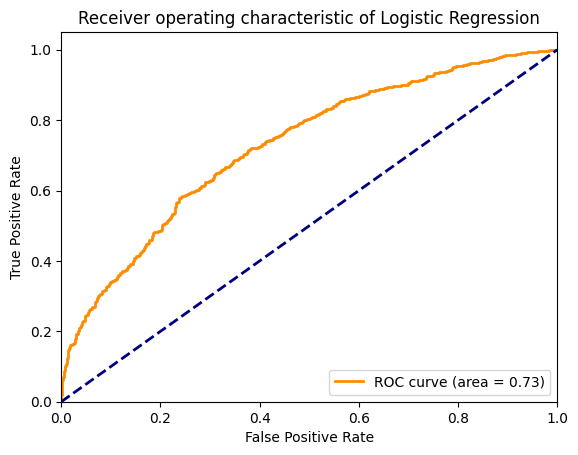

In [38]:
# evaluating each model
evaluate_model('Logistic Regression', grid_search_lr.best_estimator_, X_test, y_test)

Accuracy of Decision Tree: 0.90
Confusion Matrix:
[[ 375  179]
 [ 196 2888]]
Classification Report:
                  precision    recall  f1-score   support

           Fatal       0.66      0.68      0.67       554
Non-Fatal Injury       0.94      0.94      0.94      3084

        accuracy                           0.90      3638
       macro avg       0.80      0.81      0.80      3638
    weighted avg       0.90      0.90      0.90      3638



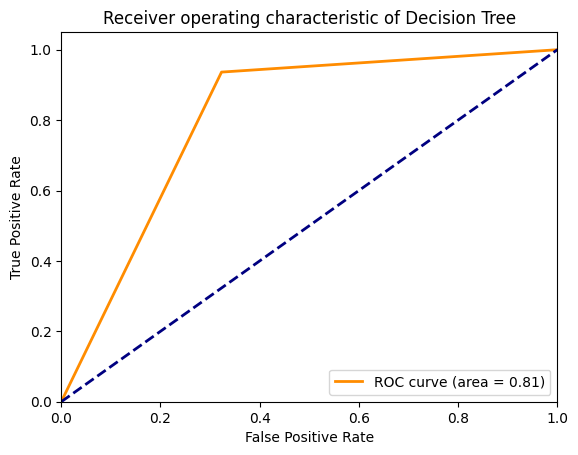

In [39]:
evaluate_model('Decision Tree', grid_search_dt.best_estimator_, X_test, y_test)

Accuracy of SVM: 0.87
Confusion Matrix:
[[ 141  413]
 [  43 3041]]
Classification Report:
                  precision    recall  f1-score   support

           Fatal       0.77      0.25      0.38       554
Non-Fatal Injury       0.88      0.99      0.93      3084

        accuracy                           0.87      3638
       macro avg       0.82      0.62      0.66      3638
    weighted avg       0.86      0.87      0.85      3638



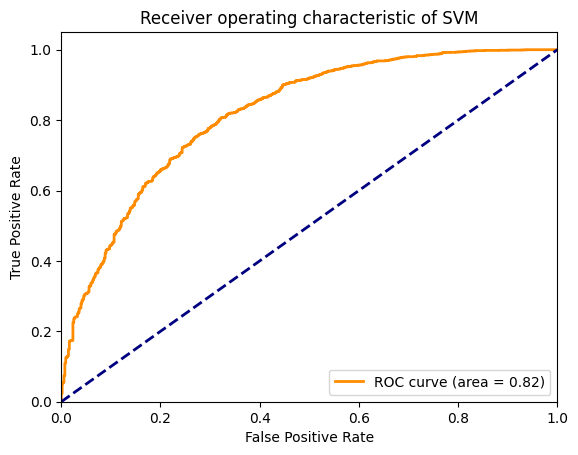

In [40]:
evaluate_model('SVM', grid_search_svm.best_estimator_, X_test, y_test)

Accuracy of Random Forest: 0.85
Confusion Matrix:
[[  27  527]
 [   1 3083]]
Classification Report:
                  precision    recall  f1-score   support

           Fatal       0.96      0.05      0.09       554
Non-Fatal Injury       0.85      1.00      0.92      3084

        accuracy                           0.85      3638
       macro avg       0.91      0.52      0.51      3638
    weighted avg       0.87      0.85      0.79      3638



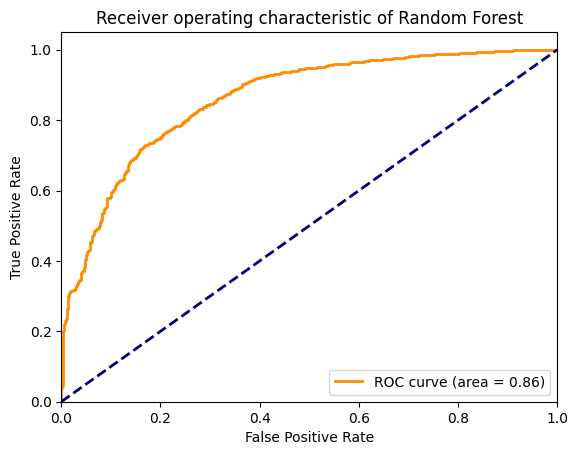

In [41]:
evaluate_model('Random Forest', grid_search_rf.best_estimator_, X_test, y_test)

Accuracy of Neural Network: 0.85
Confusion Matrix:
[[   4  550]
 [   1 3083]]
Classification Report:
                  precision    recall  f1-score   support

           Fatal       0.80      0.01      0.01       554
Non-Fatal Injury       0.85      1.00      0.92      3084

        accuracy                           0.85      3638
       macro avg       0.82      0.50      0.47      3638
    weighted avg       0.84      0.85      0.78      3638



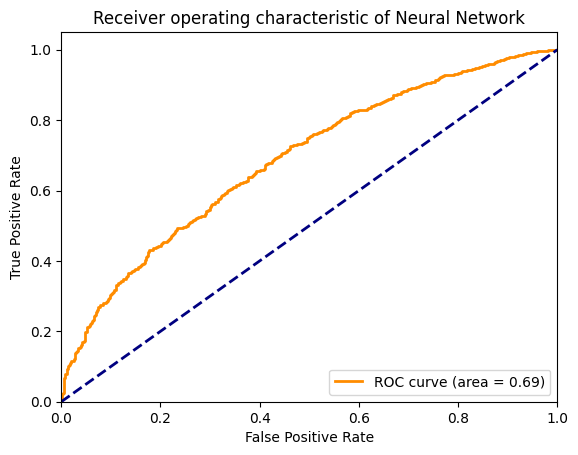

In [42]:
evaluate_model('Neural Network', grid_search_nn.best_estimator_, X_test, y_test)